In [ ]:
!conda install -y gdown

In [22]:
import torch
print("CUDA Available: ", torch.cuda.is_available())

CUDA Available:  True


In [ ]:
!pip install pandas networkx sentence-transformers

# Download subreddit submissions and comments

In [ ]:
!gdown --id 1DPugNEGWNlLp8accR8blzkQxd732DgDv

In [ ]:
!gdown --id 1kgZu_jp2iEEaWbm7Qcr2W2axcCd6LbrZ

In [ ]:
!gdown --id 1_Tqfzo07MG6bOKuUmaVTEetd11GJb1oY
!gdown --id 1PeoiZZ_CA4Blq0pjCGbAxYkNBi5Syi7c

In [ ]:
!gdown --id 1AC325OU8dqk0seehIgSToh3svXSeapnl
!gdown --id 18roQi1kYOIroMEznheJr1naGvmRjoCGN
!gdown --id 1_9YJt4uj2so90YDTfbndlaY37JQGALyN
!gdown --id 1-T1gaHrOLO_FwsIoidUeLSFuwWpPBpch
!gdown --id 1G6Pyq5eF44nzO0RcbbnNQsrnC_1OiOwZ
!gdown --id 181JIjGEoEyvETQ6xGeq-cXj4GmztZPIK

In [ ]:
!gdown --id 1pI3K9Hf6qdDi8L0W547Px52MNAaYxOsl
!gdown --id 1gHMuihxx7f6-shp1y8XVOwUJkQqBXi_v
!gdown --id 1nK4wDYqEWXiwcnXU35lqditT7Qeml4xV
!gdown --id 1AFcFDhtqyXKLICitV9jxuQzIdHUrhWTz

In [ ]:
!gdown --id 1EFRgk6Ja2LfS9AC-Tr_qhBlYngKA5nKK
!gdown --id 1n6tNedJrWbt9vJ81CneEp5_CbNBH4QyW

In [ ]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

In [ ]:
import pandas as pd
import os
import gc
import glob
import networkx as nx
from sentence_transformers import SentenceTransformer, util

# Load a pre-trained sentence transformer model for embeddings
transformer_model = SentenceTransformer('all-MiniLM-L6-v2').to('cuda')

# Filter out deleted users

In [11]:
def filter_deleted(data): # TODO: need to filter out deleted users?
    """Remove rows where the username is '[deleted]'."""

    return data[data['author'] != "[deleted]"]

# Recursive Alignment function

In [12]:
def calculate_recursive_alignment(comment_id, comments_dict, parent_alignment):
    """Recursively determine the alignment of a comment based on its parent."""
    # If the comment agrees with the parent, it inherits the parent's alignment
    if comments_dict[comment_id]['sentiment'] == parent_alignment:
        return parent_alignment  # Same alignment as the parent
    else:
        return -parent_alignment  # Opposite alignment

In [13]:
import torch

# Process one Subreddit at a time

In [18]:
def process_subreddit(submissions, comments):
    """Process submissions and comments for a single subreddit and return edges."""

    # Merge submissions and comments on link_id (removing 't3_' prefix from link_id)
    comments['link_id'] = comments['link_id'].str.split('_').str[-1]
    merged_data = pd.merge(comments, submissions, left_on='link_id', right_on='id', suffixes=('_comment', '_submission'))

    # Make a combined id for when different subreddits have the same comment id for a particular comment
    merged_data['combined_id'] = merged_data['subreddit_comment'] + '_' + merged_data['id_comment']


    duplicates = merged_data[merged_data.duplicated(subset='combined_id', keep=False)]
    if not duplicates.empty:
        print(f"Found {len(duplicates)} duplicate IDs in the 'combined_id' column.")
        print(duplicates[['combined_id', 'subreddit_comment']].head())


    merged_data['title'] = merged_data['title'].fillna("")
    merged_data['body'] = merged_data['body'].fillna("")
    # Generate embeddings for submissions and comments
    merged_data['submission_embedding'] = merged_data['title'].apply(
        lambda text: transformer_model.encode(text, convert_to_tensor=True)
    )

    merged_data['comment_embedding'] = merged_data['body'].apply(
        lambda text: transformer_model.encode(text, convert_to_tensor=True)
    )


    merged_data['similarity'] = merged_data.apply(
        lambda row: torch.dot(row['comment_embedding'], row['submission_embedding']).item(),
        axis=1
    )
    merged_data['sentiment'] = merged_data['similarity'].apply(lambda x: 1 if x >= 0 else -1)

    merged_data_unique = merged_data.drop_duplicates(subset='combined_id')
    comments_dict = merged_data_unique.set_index('combined_id').to_dict('index')


    # Recursively calculate alignment for each comment based on its parent
    for comment_id in comments_dict:
        parent_id = comments_dict[comment_id]['parent_id']
        if parent_id.startswith('t1_'):  # Ensure the parent is a comment
            parent_id = parent_id.split('_')[-1]
            if parent_id in comments_dict:  # Parent exists in the data
                parent_alignment = comments_dict[parent_id]['sentiment']
                comments_dict[comment_id]['alignment_score'] = calculate_recursive_alignment(
                    comment_id, comments_dict, parent_alignment
                )
            else:
                # If parent isn't found, assume sentiment is as-is
                comments_dict[comment_id]['alignment_score'] = comments_dict[comment_id]['sentiment']
        else:
            # If it's a top-level comment, alignment is based on the original post
            comments_dict[comment_id]['alignment_score'] = comments_dict[comment_id]['sentiment']


    # Convert the dictionary back to a DataFrame for processing
    aligned_comments = pd.DataFrame.from_dict(comments_dict, orient='index')

    # Group by user and subreddit to compute cumulative alignment scores
    user_alignment = aligned_comments.groupby(['author_comment', 'subreddit_submission'])['alignment_score'].sum().reset_index()

    # Extract edges between subreddit pairs based on shared users
    edges = []
    for user, group in user_alignment.groupby('author_comment'):
        subreddit_pairs = [(a, b) for idx, a in enumerate(group['subreddit_submission']) for b in group['subreddit_submission'][idx + 1:]]

        for sub1, sub2 in subreddit_pairs:
            align1 = group[group['subreddit_submission'] == sub1]['alignment_score'].values[0]
            align2 = group[group['subreddit_submission'] == sub2]['alignment_score'].values[0]

            # Determine edge weight based on alignment match
            weight = 1 if (align1 * align2 > 0) else -1
            edges.append((sub1, sub2, weight))

    # Free memory
    del submissions, comments, merged_data, aligned_comments, user_alignment
    gc.collect()

    return edges

# Load submissions and comments

In [19]:
import pandas as pd
import random

def load_submissions(file_path, sample_frac=0.02):
    """Load a random sample of a large CSV file."""
    subreddit = os.path.basename(file_path).split('_')[0]

    # Determine the total number of rows (including header)
    with open(file_path) as f:
        total_lines = sum(1 for line in f)

    # Calculate how many rows to skip (excluding the header)
    sample_size = int((total_lines - 1) * sample_frac)
    skip_rows = sorted(random.sample(range(1, total_lines), total_lines - 1 - sample_size))

    submissions = pd.read_csv(file_path, dtype={'author_flair_text': str}, low_memory=False, skiprows=skip_rows)
    submissions['subreddit'] = subreddit

    return filter_deleted(submissions)

def load_comments_for_submissions(comment_file, submission_ids):
    """Load only the comments related to the given submission IDs."""
    subreddit = os.path.basename(comment_file).split('_')[0]

    # Create an empty DataFrame to accumulate relevant comments
    relevant_comments = pd.DataFrame()

    # Read the comments in chunks to avoid memory overflow
    chunksize = 10000  # Adjust this based on available memory
    for chunk in pd.read_csv(comment_file, dtype={'parent_id': str, 'link_id': str}, chunksize=chunksize, low_memory=False):
        # Extract the submission ID from link_id (removing the 't3_' prefix)
        chunk['submission_id'] = chunk['link_id'].str.split('_').str[-1]

        # Filter the chunk for relevant comments
        relevant_chunk = chunk[chunk['submission_id'].isin(submission_ids)]

        # Append relevant comments to the DataFrame
        relevant_comments = pd.concat([relevant_comments, relevant_chunk], ignore_index=True)

    relevant_comments['subreddit'] = subreddit
    # Filter out deleted users
    return filter_deleted(relevant_comments)

def filter_files_by_subreddits(files, subreddits):
    """Filter the files based on the specified subreddits."""
    return [f for f in files if any(subreddit in f for subreddit in subreddits)]

def filter_users_in_multiple_subreddits(submissions, comments):
    """Filter out users who have entries in only one subreddit."""

    # Combine submissions and comments into one DataFrame for filtering
    combined_data = pd.concat([submissions[['author', 'subreddit']], comments[['author', 'subreddit']]],
                              ignore_index=True)

    # Group by author to check how many unique subreddits each user has contributed to
    author_subreddit_counts = combined_data.groupby('author')['subreddit'].nunique().reset_index()

    # Filter out users who have contributed to only one subreddit
    authors_with_multiple_subreddits = author_subreddit_counts[author_subreddit_counts['subreddit'] > 1]['author']

    # Filter the submissions and comments for these users
    filtered_submissions = submissions[submissions['author'].isin(authors_with_multiple_subreddits)]
    filtered_comments = comments[comments['author'].isin(authors_with_multiple_subreddits)]

    return filtered_submissions, filtered_comments

In [20]:
import os

# List all files in the current directory
print(os.listdir('.'))

['climatechange_comments.csv', '.virtual_documents', 'Conservative_submissions.csv', 'climatechange_submissions.csv', 'socialism_comments.csv', 'socialism_submissions.csv', 'climateskeptics_comments.csv', 'progressive_submissions.csv', 'Liberal_comments.csv', 'Liberal_submissions.csv', 'energy_comments.csv', 'climateskeptics_submissions.csv', 'Conservative_comments.csv', 'progressive_comments.csv', 'energy_submissions.csv', 'climate_comments.csv', 'climate_submissions.csv']


# Calculate edges

In [ ]:
import glob

# Get the list of submission and comment files
subreddits_to_process = ['climate', 'climateskeptics', 'climatechange', 'Conservative', 'Liberal', 'progressive', 'energy', 'socialism']



# Get the paths for submission and comment files
submission_files = glob.glob('./*_submissions.csv')  # Current directory
comment_files = glob.glob('./*_comments.csv')

# Filter files by the specified subreddits
submission_files = filter_files_by_subreddits(submission_files, subreddits_to_process)
comment_files = filter_files_by_subreddits(comment_files, subreddits_to_process)

# Initialize empty DataFrames
all_submissions = pd.DataFrame()
all_comments = pd.DataFrame()

# Load and combine submissions
for submission_file in submission_files:
    submissions = load_submissions(submission_file)
    all_submissions = pd.concat([all_submissions, submissions], ignore_index=True)


# Load and combine comments linked to the sampled submissions
for comment_file in comment_files:
    sampled_submission_ids = all_submissions['id'].astype(str).tolist()
    comments = load_comments_for_submissions(comment_file, sampled_submission_ids)
    
    # Check if the comment file is for 'Conservative' and limit to 10,000 comments
    if "Conservative" in comment_file:
        comments = comments.head(10000)  # Take only the first 10,000 comments
    
    all_comments = pd.concat([all_comments, comments], ignore_index=True)

# Filter users appearing in multiple subreddits
all_submissions, all_comments = filter_users_in_multiple_subreddits(all_submissions, all_comments)

# Summary statistics
print(f"Total Submissions: {len(all_submissions)}, Total Comments: {len(all_comments)}")

# Count unique users
unique_users = pd.concat([all_submissions['author'], all_comments['author']]).nunique()
print(f"Number of unique users after filtering: {unique_users}")

# Process combined data and create edges
edges = process_subreddit(all_submissions, all_comments)
print(f"Total Edges: {len(edges)}")

# # Save edges to a file
# output_file = './subreddit_edges7.txt'
# with open(output_file, 'w') as f:
#     for edge in edges:
#         f.write(f"{edge[0]},{edge[1]},{edge[2]}\n")

# print(f"Edges saved to {output_file}")

In [ ]:
edges

# Save edges to file

In [23]:
# Save edges to a file
output_file = './subreddit_edges9.txt'
with open(output_file, 'w') as f:
    for edge in edges:
        f.write(f"{edge[0]},{edge[1]},{edge[2]}\n")

print(f"Edges saved to {output_file}")

Edges saved to ./subreddit_edges9.txt


In [24]:
file_path = './subreddit_edges9.txt'  # Replace with the path to your .txt file
num_lines = 5  # Number of lines to read

try:
    # Open the file in read mode
    with open(file_path, 'r') as file:
        # Read the specified number of lines
        for i in range(num_lines):
            line = file.readline()
            # Break if the end of the file is reached
            if not line:
                break
            print(line.strip())  # Strip newline characters and print the line
except FileNotFoundError:
    print(f"Error: The file '{file_path}' does not exist.")
except Exception as e:
    print(f"An error occurred: {e}")

energy,progressive,1
Conservative,Liberal,1
energy,progressive,1
Liberal,progressive,1
climate,progressive,1


# Graph

In [25]:
# Initialize the final graph
G = nx.Graph()

# Load all saved edges and add them to the graph
for edge_file in glob.glob('./subreddit_edges9.txt'):
    with open(edge_file, 'r') as f:
        for line in f:
            sub1, sub2, weight = line.strip().split(',')
            weight = int(weight)

            # Add edge to the graph
            if G.has_edge(sub1, sub2):
                G[sub1][sub2]['weight'] += weight
            else:
                G.add_edge(sub1, sub2, weight=weight)

# Save the final graph
nx.write_gexf(G, 'subreddit_alignment_graph9.gexf')

In [26]:
G.edges()

EdgeView([('energy', 'progressive'), ('energy', 'climateskeptics'), ('energy', 'climate'), ('energy', 'climatechange'), ('energy', 'socialism'), ('energy', 'Liberal'), ('energy', 'Conservative'), ('progressive', 'Liberal'), ('progressive', 'climate'), ('progressive', 'socialism'), ('progressive', 'Conservative'), ('progressive', 'climateskeptics'), ('Conservative', 'Liberal'), ('Conservative', 'climateskeptics'), ('Conservative', 'socialism'), ('Conservative', 'climate'), ('Conservative', 'climatechange'), ('Liberal', 'climate'), ('Liberal', 'socialism'), ('Liberal', 'climateskeptics'), ('Liberal', 'climatechange'), ('climate', 'climateskeptics'), ('climate', 'climatechange'), ('climate', 'socialism'), ('climateskeptics', 'socialism'), ('climateskeptics', 'climatechange'), ('socialism', 'climatechange')])

/tmp/ipykernel_23/653153340.py:54: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='Edge Weight')


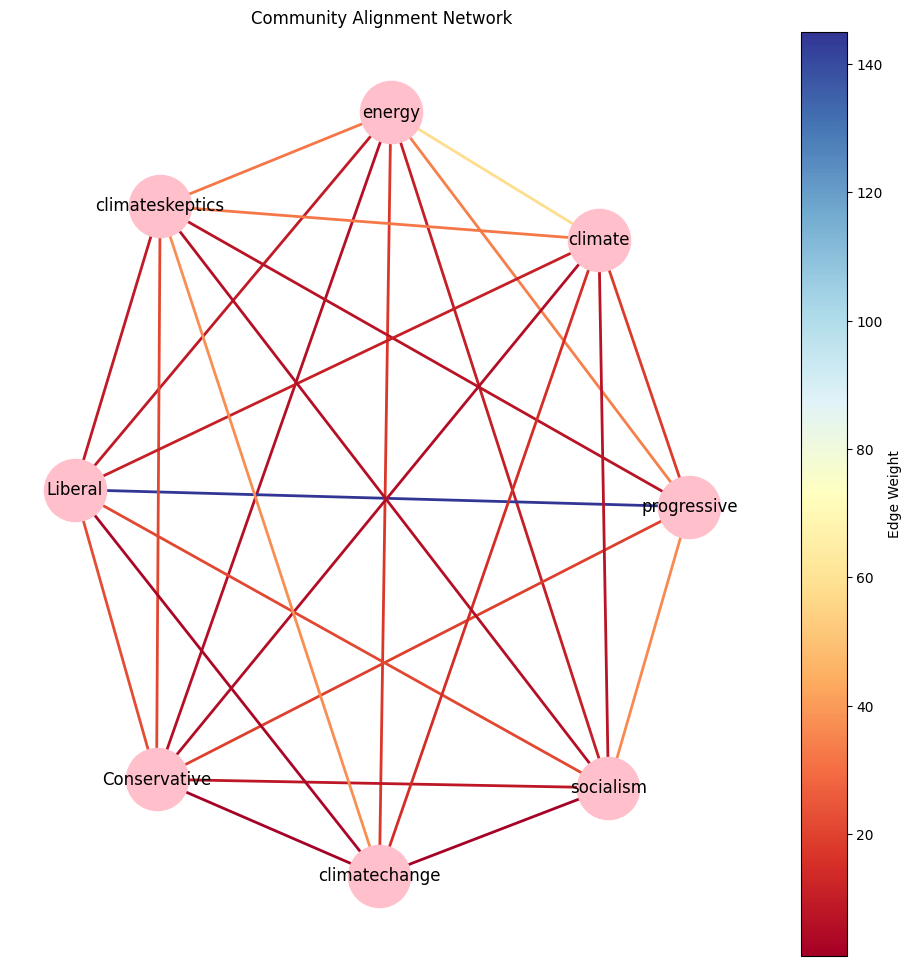

In [27]:
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import networkx as nx
import glob

weights = [G[u][v]['weight'] for u, v in G.edges()]
# Define colormap and normalize based on the conflict score range
cmap = plt.cm.RdYlBu
norm = mcolors.Normalize(vmin=min(weights),
                          vmax=max(weights))


# Draw the graph
plt.figure(figsize=(12, 12))  # Set the figure size for better visibility
pos = nx.spring_layout(G, seed=42, k=50, iterations=100)

# Draw nodes and edges
nx.draw_networkx_nodes(G, pos, node_size=2000, node_color='pink')
nx.draw_networkx_labels(G, pos)
nx.draw_networkx_edges(
    G, pos,
    edgelist=G.edges,
    edge_color=weights,
    edge_cmap=cmap,
    edge_vmin=min(weights), 
    edge_vmax=max(weights), 
    width=2
)

# # Draw nodes with customized color
# node_colors = [G.degree(n) for n in G.nodes()]  # Node color based on degree
# nx.draw_networkx_nodes(
#     G, pos, 
#     node_size=500, 
#     node_color=node_colors, 
#     cmap=plt.cm.viridis, 
#     alpha=0.9
# )

# # Draw edges with color mapped to weights
# nx.draw_networkx_edges(
#     G, pos, 
#     edge_color=weights, 
#     edge_cmap=cmap, 
#     edge_vmin=min(weights), 
#     edge_vmax=max(weights), 
#     width=2, 
#     alpha=0.7
# )

# Add colorbar explicitly
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array(weights)  # Attach edge weights to colorbar
plt.colorbar(sm, label='Edge Weight')

# Show graph
plt.title("Community Alignment Network")
plt.axis("off")
plt.show()


# # Draw labels
# nx.draw_networkx_labels(G, pos, font_size=10, font_color='black')

# # Add edge weights as labels (optional, can be removed for cleaner visualization)
# edge_labels = nx.get_edge_attributes(G, 'weight')
# nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)

# # Add colorbar for edge weights
# sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
# sm.set_array(weights)
# plt.colorbar(sm, label='Edge Weight')

# # Show the graph
# plt.title("Subreddit Alignment Graph", fontsize=16)
# plt.axis('off')  # Turn off axis
# plt.show()